In [1]:
import random
from collections import defaultdict

import gym
import gym.spaces as spaces
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import Generator
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import stable_baselines3 as sb3

from envs.robots.robot_arm import RobotArm
from supervised.data import \
    TargetGaussianDataset as SupervisedTargetGaussianDataset
from supervised.loss import PointDistanceLoss
from supervised.utils import forward_kinematics
from vae.data.load_data_set import TargetGaussianDataset

In [2]:
df_start = pd.read_csv("datasets/2/train/state_IK_random_start.csv")
df_action = pd.read_csv("datasets/2/train/actions_IK_random_start.csv")

In [3]:
class WrapperDataset(Dataset):
    def __init__(self, path, supervised=True) -> None:
        if not supervised:
            self.data = TargetGaussianDataset(path, 0.2)
        else:
            self.data = SupervisedTargetGaussianDataset(path, 0.2)
        self.supervised = supervised

    def __getitem__(self, idx):
        if self.supervised:
            x, y = self.data[idx]
            x = x.detach()
            return x, y

        x, cond_enc, cond_dec, y = self.data[idx]
        x = torch.cat([x, cond_enc.detach()])
        # x: delta to target, curr pos, curr angles
        return x, y
    
    def __len__(self):
        return len(self.data)
    

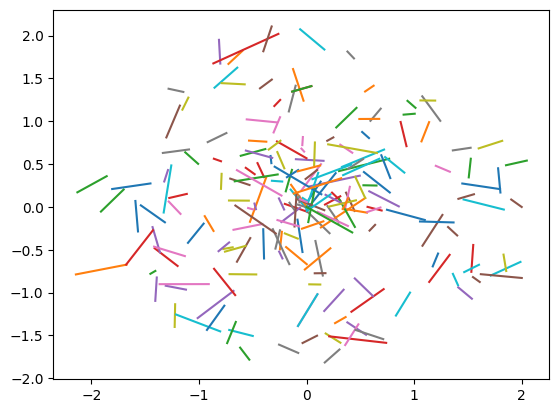

In [4]:
dataset = WrapperDataset("datasets/2/train/state_IK_random_start.csv")

for x, y in random.choices(dataset, k=200):
    curr_pos = x[2: 4]
    target_pos = y
    data = np.stack([curr_pos, target_pos])
    plt.plot(data[:, 0], data[:, 1])

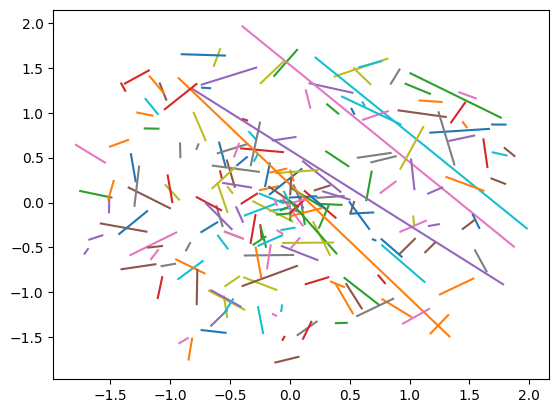

In [5]:
dataset = WrapperDataset("datasets/2/train/state_IK_random_start.csv", supervised=False)

for x, y in random.choices(dataset, k=200):
    curr_pos = x[2: 4]
    target_pos = y
    data = np.stack([curr_pos, target_pos])
    plt.plot(data[:, 0], data[:, 1])

##### Question: What is happening in the plot above?

In [6]:
model = nn.Sequential(nn.Linear(6, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
optim = Adam(model.parameters(), lr=0.0003)

In [7]:
EPOCHS = 100
train_dataset = WrapperDataset("datasets/2/train/state_IK_random_start.csv")
train_loader = DataLoader(train_dataset, 32)
val_dataset = WrapperDataset("datasets/2/val/state_IK_random_start.csv")
val_loader = DataLoader(val_dataset, 256)



def loss_fn(angles, y):
    pos = forward_kinematics(angles)[:, -1]
    return F.huber_loss(pos, y)

# loss_fn = PointDistanceLoss("cpu")

stats = defaultdict(list)


for idx in range(EPOCHS):
    train_losses = []

    for x, y in train_loader:
        angles = model(x)
        loss = loss_fn(angles, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_losses.append(loss.item())

    with torch.no_grad():
        stats["val_loss"].append(np.mean([loss_fn(model(x), y) for x, y in val_loader]))
    stats["train_loss"].append(np.mean(train_losses))

    if idx % 10 == 0:
        print("train loss: ", stats["train_loss"][-1], "val_loss: ", stats["val_loss"][-1])


train loss:  0.11526084402962901 val_loss:  0.023345347
train loss:  0.0035404323884018194 val_loss:  0.0031059831
train loss:  0.002561103079479914 val_loss:  0.0020946963
train loss:  0.0020899786929095597 val_loss:  0.0017489999
train loss:  0.0017154468287611173 val_loss:  0.0015800705
train loss:  0.0015371051266790923 val_loss:  0.0020646988
train loss:  0.0013778406170608935 val_loss:  0.0013673927
train loss:  0.0013980342562648113 val_loss:  0.0010646086
train loss:  0.001165915167373129 val_loss:  0.0010328119
train loss:  0.0011230381708718633 val_loss:  0.0010166473


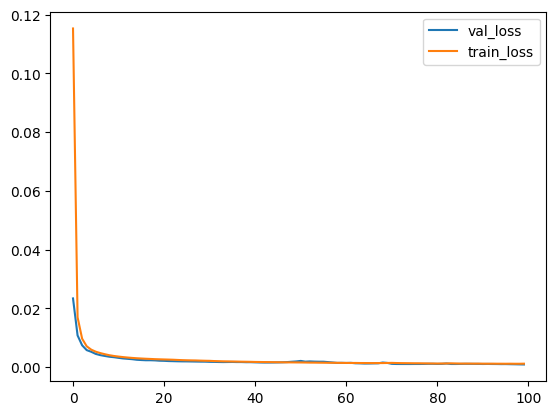

In [8]:
plt.plot(stats["val_loss"], label="val_loss")
plt.plot(stats["train_loss"], label="train_loss")
plt.legend()

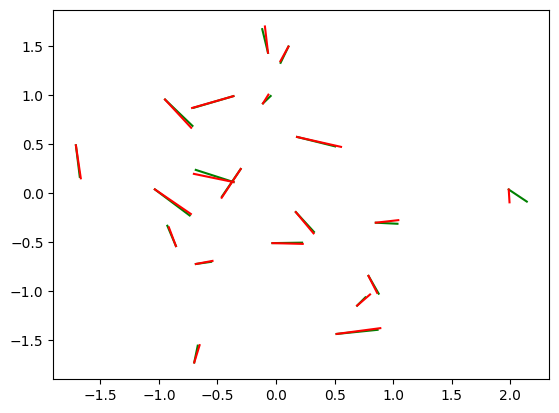

In [9]:
dataset = WrapperDataset("datasets/2/train/state_IK_random_start.csv")

for x, y in random.choices(dataset, k=20):
    with torch.no_grad():
        pred = model(x)[None, :]

    model_pos = forward_kinematics(pred)[0, -1]
    curr_pos = x[2: 4]
    target_pos = y
    data = np.stack([curr_pos, target_pos])
    data_pred = np.stack([curr_pos, model_pos])
    plt.plot(data[:, 0], data[:, 1], color="green")
    plt.plot(data_pred[:, 0], data_pred[:, 1], color="red")

### RL Env

In [10]:


def sample_pt(rng: Generator, n: int):
    phi = rng.uniform(0, 2 * np.pi)
    scale = rng.uniform(0, n)
    return np.array([scale * np.cos(phi), scale * np.sin(phi), 1])

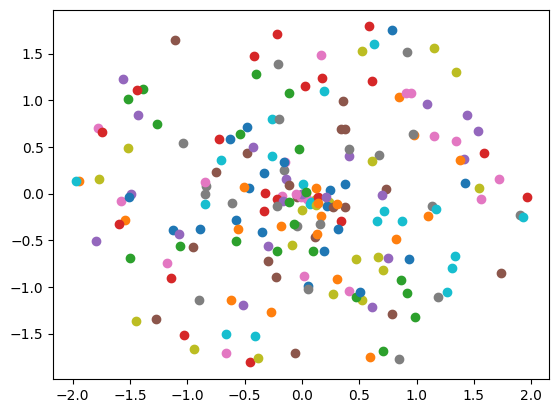

In [11]:
rng = np.random.default_rng(0)

for _ in range(200):
    plt.scatter(*sample_pt(rng, 2)[: 2])

In [12]:


# label_angles, _, _, _ = IK(
#     new_target,
#     np.rad2deg(state_angles[state_idx]).copy(),
#     np.ones_like(state_angles[state_idx]),
#     err_min=0.001)

arm = RobotArm(2)
target = sample_pt(rng, 2)
print(arm.end_position)
arm.IK(target, error_min=0.001)
print(arm.end_position)
print(target)

[2. 0.]
[0.55535459 1.79076648]
[0.55530158 1.79173216 1.        ]


In [13]:
class Army(gym.Env):
    def __init__(self, n=2, model=None):
        super().__init__()
        self.n = n
        self.model = model
        self.eps = 0.2
        self.max_steps = 100

        self.rng = np.random.default_rng(0)
        self.arm = RobotArm(n)
        self.target_pos = None
        self.curr_step = 0

        dim = 4 + self.n
        self.observation_space = spaces.Box(np.full(dim, -np.inf), np.full(dim, np.inf))
        cons = np.array([0.3, 0.3])
        self.action_space = spaces.Box(-cons, cons)

    def seed(self, seed: int = 0):
        self.rng = np.random.default_rng(seed)

    def obs(self):
        return np.concatenate([self.target_pos[:2], self.arm.positions[-1], self.arm.angles])

    def reset(self):
        start_pos = sample_pt(self.rng, self.arm.n_joints)
        arm.IK(start_pos, error_min=0.001)
        self.target_pos = sample_pt(self.rng, self.arm.n_joints)
        self.curr_step = 0
        return self.obs()
    
    def step(self, action):
        obs = np.concatenate([action, self.obs()[2: ]])
        obs = torch.from_numpy(obs)[None, :].float()
        with torch.no_grad():
            angle = self.model(obs)[0].numpy()

        self.arm.set(angle)
        distance = np.linalg.norm(self.target_pos[: 2] - self.arm.end_position)
        done = True if distance < self.eps else False

        self.curr_step += 1
        if self.curr_step == self.max_steps:
            done = True

        return self.obs(), -distance, done, {}

    def render(self, fig=None, ax=None, color="k"):
        if fig is None or ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.set_xlim([-2.2, 2.2])
        ax.set_ylim([-2.2, 2.2])
        ax.scatter(*self.target_pos[:2])

        for p1, p2 in zip(self.arm.positions, self.arm.positions[1: ]):
            data = np.stack([p1, p2])
            ax.plot(data[:, 0], data[:, 1], color=color, marker=".", alpha=2/5)

        return fig, ax

    def direction(self, max_length=0.4):
        delta = self.target_pos[: 2] - self.arm.end_position
        norm = np.linalg.norm(delta, 2)
        scaling = 1 if norm < max_length else max_length / norm
        return scaling * delta
 

-1.3787048056134374 False
-1.0160446320593985 False
-0.633405515794224 False
-0.25819428297132224 False
-0.017382094734065802 True
-0.024641848803403615 True
-0.03408368031422109 True
-0.038738554301488246 True
-0.04112592917707429 True
-0.04238031116225767 True
-0.04304891369817869 True
-0.04340837819479595 True
-0.043603239839877364 True
-0.04370886410129022 True
-0.04376643519871684 True
-0.04379827887393326 True
-0.04381565652850163 True
-0.04382507318740549 True
-0.043830319421094256 True
-0.043833389048218575 True
-0.04383492391587302 True
-0.043835802951944364 True
-0.043836445152662724 True
-0.04383643148606142 True
-0.04383666833271312 True
-0.04383678675604537 True
-0.04383668199924059 True
-0.04383668199924059 True
-0.04383668199924059 True
-0.04383668199924059 True
-0.04383668199924059 True
-0.04383668199924059 True
-0.04383668199924059 True
-0.04383668199924059 True
-0.04383668199924059 True
-0.04383668199924059 True
-0.04383668199924059 True
-0.04383668199924059 True
-0.0

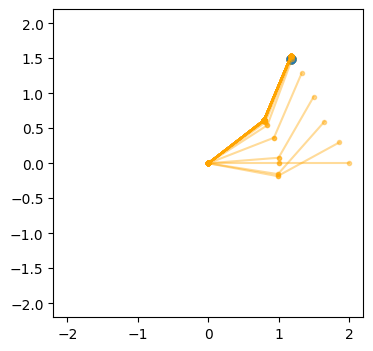

In [25]:
seed = 1
color = "orange"

env = Army(model=model)
env.seed(seed)
obs = env.reset()
fig, ax = env.render(color=color)
done = False


for _ in range(50):
    direction = env.direction()
    obs, reward, done, info = env.step(direction)
    print(reward, done)
    env.render(fig, ax, color=color)

In [15]:
alg = sb3.SAC("MlpPolicy", env, verbose=1)
alg.learn(20000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 65.2     |
|    ep_rew_mean     | -74.3    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 247      |
|    time_elapsed    | 1        |
|    total_timesteps | 261      |
| train/             |          |
|    actor_loss      | -1.6     |
|    critic_loss     | 0.137    |
|    ent_coef        | 0.953    |
|    ent_coef_loss   | -0.159   |
|    learning_rate   | 0.0003   |
|    n_updates       | 160      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 61.1     |
|    ep_rew_mean     | -89.7    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 179      |
|    time_elapsed    | 2        |
|    total_timesteps | 489      |
| train/             |

[-0.29967427  0.29740143]
-1.1084650604202169 False
[-0.29669037  0.21688575]
-0.7683892581435043 False
[-0.28422803  0.07830444]
-0.501628427772077 False
[-0.11293006  0.24116457]
-0.35482963181876354 False
[-0.1967513   0.07713863]
-0.19034303545458514 True


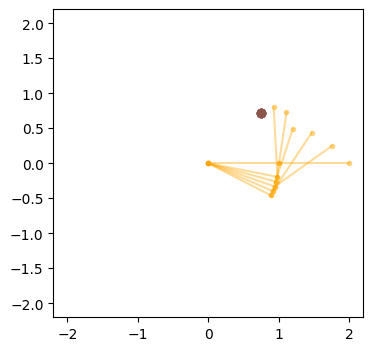

In [29]:
seed = 20
color = "orange"

env = Army(model=model)
env.seed(seed)
obs = env.reset()
fig, ax = env.render(color=color)
done = False


for _ in range(100):
    direction, _ = alg.policy.predict(obs)
    print(direction)
    obs, reward, done, info = env.step(direction)
    print(reward, done)
    env.render(fig, ax, color=color)

    if done:
        break